### Task 1: Exploratory Data Analysis (EDA)

This notebook explores and cleans the CFPB consumer complaint dataset for use in a Retrieval-Augmented Generation (RAG) system.

In [1]:
import pandas as pd

In [2]:
#Load the dataset
df = pd.read_csv("../data/raw/complaints.csv")

C:\Users\ourbarn\AppData\Local\Temp\ipykernel_13372\2789423713.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/complaints.csv")


In [3]:
df.shape

(7634283, 18)

In [4]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [5]:
mis = df['Consumer complaint narrative'].isna().sum()

In [6]:
all = df.shape[0]
mis_percent = (mis / all) * 100
mis_percent

np.float64(68.99742909713984)

When checking the missing values in the key column of "Consumer complaint narrative" we got around 69% missing data. But since our RAG works with text data we should remove the null values or take only the rows with that data.

In [7]:
df_text = df[df['Consumer complaint narrative'].notna()]

In [8]:
df_text.shape

(2366824, 18)

In [9]:
df_text.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
76,2025-03-06,Credit reporting or other personal consumer re...,Credit reporting,Problem with fraud alerts or security freezes,NaN,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX Apt XX...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,75211,NaN,Consent provided,Web,2025-03-06,Closed with explanation,Yes,NaN,12351447.0
359,2025-02-26,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information is missing that should be on the r...,Subject : Dispute of Unauthorized Hard Inquiri...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,331XX,NaN,Consent provided,Web,2025-02-26,Closed with explanation,Yes,NaN,12203565.0
11499,2025-06-15,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,Changes in loan terms during the application p...,I signed a purchase agreement with Lennar Corp...,Company has responded to the consumer and the ...,"Lennar Financial Services, LLC",IL,60538,NaN,Consent provided,Web,2025-06-15,Closed with explanation,Yes,NaN,14089944.0
11973,2025-06-14,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,"After checking my report, I found numerous acc...",Company has responded to the consumer and the ...,"Fidelity National Information Services, Inc. (...",FL,32303,NaN,Consent provided,Web,2025-06-14,Closed with explanation,Yes,NaN,14080390.0
12237,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121.0


In [10]:
allowed_products = [
    "Credit card",
    "Credit card or prepaid card",
    "Payday loan, title loan, or personal loan",
    "Payday loan, title loan, personal loan, or advance loan",
    "Consumer Loan",
    "Checking or savings account",
    "Money transfer, virtual currency, or money service",
    "Money transfers"
]

In [11]:
filtered_df = df_text[df_text['Product'].isin(allowed_products)]

In [12]:
filtered_df['Product'].value_counts()

Product
Checking or savings account                                109333
Credit card or prepaid card                                 89737
Money transfer, virtual currency, or money service          83182
Credit card                                                 53777
Payday loan, title loan, or personal loan                   14322
Consumer Loan                                                6929
Payday loan, title loan, personal loan, or advance loan      5866
Money transfers                                              1146
Name: count, dtype: int64

In [13]:
filtered_df.shape

(364292, 18)

In [16]:
filtered_df.loc[:,'word_count'] = (filtered_df['Consumer complaint narrative'].astype(str).apply(lambda x: len(x.split())))

In [17]:
filtered_df['word_count'].describe()

count    364292.000000
mean        202.904620
std         225.621466
min           1.000000
25%          83.000000
50%         133.000000
75%         251.000000
max        6469.000000
Name: word_count, dtype: float64

This result shows us that some customers have very small complaints even containing one word which is difficult to get the context out of it and some have very long narratives which can cover pages like those having 6469 words. To enable an ease of embedding, we need to clean this.

In [18]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Distribution of Complaint Lentgth')

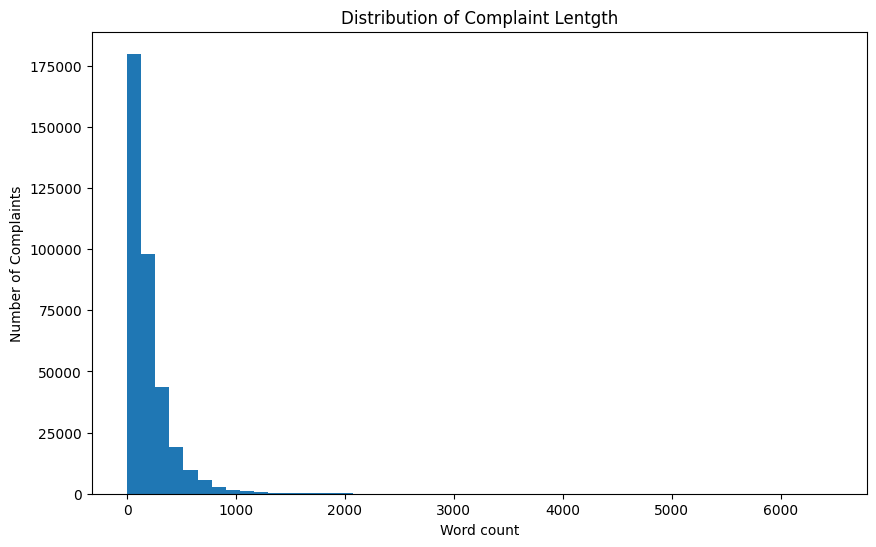

In [20]:
plt.figure(figsize=(10,6))
plt.hist(filtered_df['word_count'], bins=50)
plt.xlabel('Word count')
plt.ylabel('Number of Complaints')
plt.title('Distribution of Complaint Lentgth')

In [21]:
import re
def clean_text(text):
    # convert to lower case
    text = str(text).lower()
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # remove special characters and digits
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

In [22]:
filtered_df.loc[:, 'cleaned_narrative'] = (filtered_df['Consumer complaint narrative'].apply(clean_text))

C:\Users\ourbarn\AppData\Local\Temp\ipykernel_13372\1914730107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'cleaned_narrative'] = (filtered_df['Consumer complaint narrative'].apply(clean_text))


In [23]:
filtered_df[['Consumer complaint narrative', 'cleaned_narrative']].head()

,Consumer complaint narrative,cleaned_narrative
12237,A XXXX XXXX card was opened under my name by a...,a xxxx xxxx card was opened under my name by a...
12532,I made the mistake of using my wellsfargo debi...,i made the mistake of using my wellsfargo debi...
13280,"Dear CFPB, I have a secured credit card with c...",dear cfpb i have a secured credit card with ci...
13506,I have a Citi rewards cards. The credit balanc...,i have a citi rewards cards the credit balance...
13955,b'I am writing to dispute the following charge...,bi am writing to dispute the following charges...


In [29]:
filtered_df.shape

(364292, 20)

In [30]:
filtered_df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'word_count',
       'cleaned_narrative'],
      dtype='object')

In [31]:
filtered_df = filtered_df.drop(columns=['word_count'])

In [32]:
output_path = "../data/processed/filtered_complaints.csv"
filtered_df.to_csv(output_path, index=False)